## 1. Import Library dan Inisialisasi


In [1]:
# Import library yang diperlukan
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Unduh paket NLTK yang diperlukan (hanya perlu sekali)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\khairul
[nltk_data]     iman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Muat Dataset


In [33]:
# Muat file JSON yang berisi intents dan pola-pola percakapan
with open('stunting_intents.json', 'r') as file:
    intents = json.load(file)

# Inisialisasi list untuk menyimpan kata-kata, kelas (tag), dan dokumen
words = []
classes = []
documents = []
ignore_words = ['?', '!', '.', ',', '"', "'"] # Kata-kata yang akan diabaikan

# Iterasi melalui setiap intent dan pola untuk tokenisasi dan pengumpulan data
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Tokenisasi setiap kata dalam pola
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # Tambahkan pasangan (pola_token, tag_intent) ke dokumen
        documents.append((w, intent['tag']))
        # Tambahkan tag intent ke daftar kelas jika belum ada
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

## 3. Preprocessing Data


In [34]:
# Lemmatisasi setiap kata, ubah ke huruf kecil, dan hapus kata yang diabaikan
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
# Hapus duplikat dan urutkan kata-kata
words = sorted(list(set(words)))
# Urutkan kelas (tag)
classes = sorted(list(set(classes)))

# Simpan daftar kata-kata dan kelas ke file pickle
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

print(f"Jumlah kata unik: {len(words)}")
print(f"Jumlah kelas (intents): {len(classes)}")
print(f"Jumlah dokumen (pasangan pola-tag): {len(documents)}")

Jumlah kata unik: 924
Jumlah kelas (intents): 33
Jumlah dokumen (pasangan pola-tag): 1120


## 4. Membuat Data Pelatihan (Bag of Words)


In [35]:
# Inisialisasi list untuk data pelatihan
training = []
# Buat array kosong untuk output, ukurannya sama dengan jumlah kelas
output_empty = [0] * len(classes)

# Iterasi melalui setiap dokumen
for doc in documents:
    # Inisialisasi bag of words untuk setiap pola
    bag = []
    # Lemmatisasi pola kata
    pattern_words = [lemmatizer.lemmatize(w.lower()) for w in doc[0]]
    # Buat bag of words: 1 jika kata ada di pola, 0 jika tidak
    for w in words:
        bag.append(1 if w in pattern_words else 0)
    
    # Buat baris output (one-hot encoding) untuk tag intent
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1 # Set 1 pada indeks kelas yang sesuai
    
    # Tambahkan bag of words dan output row ke data pelatihan
    training.append([bag, output_row])

# Acak data pelatihan untuk memastikan distribusi yang baik
random.shuffle(training)
# Konversi ke numpy array
training = np.array(training, dtype=object)

# Pisahkan fitur (X) dan label (Y)
train_x = list(training[:, 0])
train_y = list(training[:, 1])

print(f"Ukuran data pelatihan (fitur): {len(train_x)}x{len(train_x[0])}")
print(f"Ukuran data pelatihan (label): {len(train_y)}x{len(train_y[0])}")

Ukuran data pelatihan (fitur): 1120x924
Ukuran data pelatihan (label): 1120x33


## 5. Membagi Data untuk Validasi


In [36]:
# Bagi data pelatihan menjadi set pelatihan dan validasi
# test_size=0.2 berarti 20% data akan digunakan untuk validasi
# stratify=train_y memastikan distribusi kelas yang sama di set pelatihan dan validasi
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y, random_state=42)

print(f"Ukuran set pelatihan (fitur): {len(X_train)}x{len(X_train[0])}")
print(f"Ukuran set validasi (fitur): {len(X_val)}x{len(X_val[0])}")

Ukuran set pelatihan (fitur): 896x924
Ukuran set validasi (fitur): 224x924


## 6. Membuat Model Neural Network


In [37]:
# Inisialisasi model Sequential
model = Sequential()

# Layer input dan hidden pertama
# Input shape adalah ukuran bag of words (jumlah kata unik)
# Menggunakan aktivasi ReLU (Rectified Linear Unit)
model.add(Dense(256, input_shape=(len(train_x[0]),), activation='relu'))
# Dropout layer untuk mencegah overfitting (mengabaikan 50% neuron secara acak)
model.add(Dropout(0.5))

# Layer hidden kedua
model.add(Dense(128, activation='relu'))
# Dropout layer kedua
model.add(Dropout(0.5))

# Layer output
# Jumlah neuron sama dengan jumlah kelas (intents)
# Menggunakan aktivasi softmax untuk probabilitas output
model.add(Dense(len(train_y[0]), activation='softmax'))

model.summary()

d:\Anaconda3\envs\tensorFlow_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │       236,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,953 (1.05 MB)

 Trainable params: 273,953 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Kompilasi Model


In [38]:
# Konfigurasi optimizer Adam dengan learning rate 0.001
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## 8. Latih Model dengan EarlyStopping


In [39]:
early_stop = EarlyStopping(monitor='loss', patience=0, mode='min', min_delta=0, restore_best_weights=True, verbose=1)

hist = model.fit(
    np.array(X_train), np.array(y_train),
    epochs=300,
    batch_size=8,
    validation_data=(np.array(X_val), np.array(y_val)),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0355 - loss: 3.4777 - val_accuracy: 0.3304 - val_loss: 3.3202
Epoch 2/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2165 - loss: 3.2258 - val_accuracy: 0.4152 - val_loss: 2.7926
Epoch 3/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4025 - loss: 2.5992 - val_accuracy: 0.5223 - val_loss: 2.0850
Epoch 4/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5360 - loss: 1.9187 - val_accuracy: 0.6071 - val_loss: 1.6871
Epoch 5/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6319 - loss: 1.5562 - val_accuracy: 0.6250 - val_loss: 1.4775
Epoch 6/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7184 - loss: 1.1765 - val_accuracy: 0.6473 - val_loss: 1.3387
Epoch 7/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7861 - loss: 0.9228 - val_accuracy: 0.6741 - val_loss: 1.2787
Epoch 8/300
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8091 - loss: 0.7802 - val_accu

## 9. Simpan Model


In [40]:
# Simpan model yang telah dilatih ke file .h5
model.save("chatbot_model.h5")
print("Model trained and saved successfully!")

Model trained and saved successfully!


## 10. Evaluasi Model


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Akurasi Validasi: 66.52%

Classification Report:
                         precision    recall  f1-score   support

      1000 hari pertama       1.00      1.00      1.00         6
          ASI eksklusif       1.00      1.00      1.00         5
                  MPASI       1.00      1.00      1.00         7
       anak picky eater       0.71      0.71      0.71         7
               aplikasi       0.83      0.50      0.62        10
       berat badan anak       0.50      0.43      0.46         7
        dampak stunting       0.60      0.50      0.55         6
           deteksi dini       0.00      0.00      0.00         7
           edukasi gizi       0.80      0.80      0.80        10
          gizi seimbang       0.50      0.50      0.50         6
              ibu hamil       0.67      0.67      0.67         9
              imunisasi       1.00      0.75      0.86         8
                   kamu       1.00      1.00      1.00         1
 

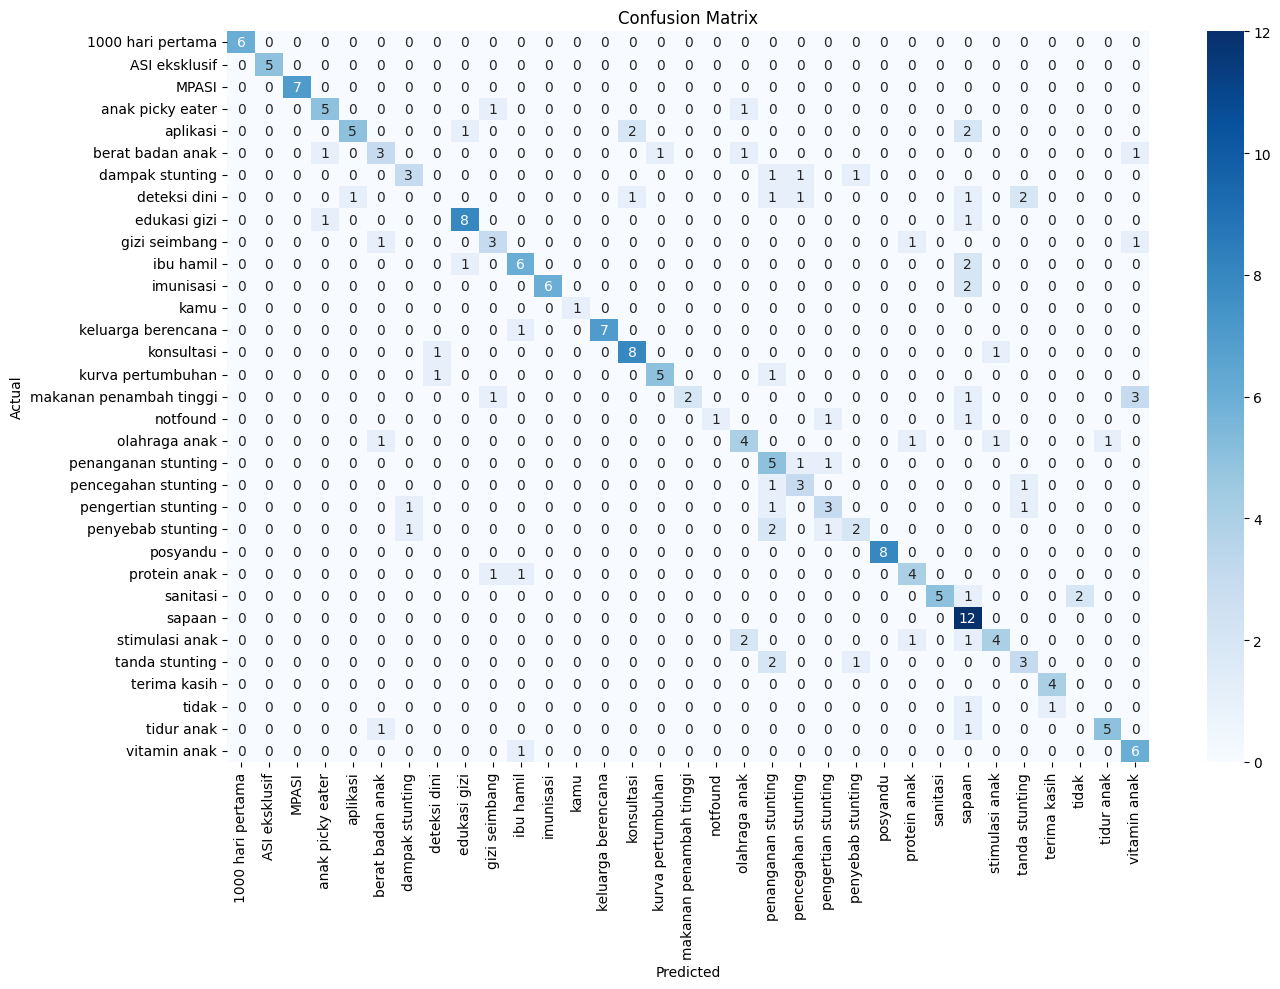

In [41]:
# Prediksi pada data validasi
y_pred = model.predict(np.array(X_val))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(np.array(y_val), axis=1)

# Akurasi validasi
val_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"\nAkurasi Validasi: {val_accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

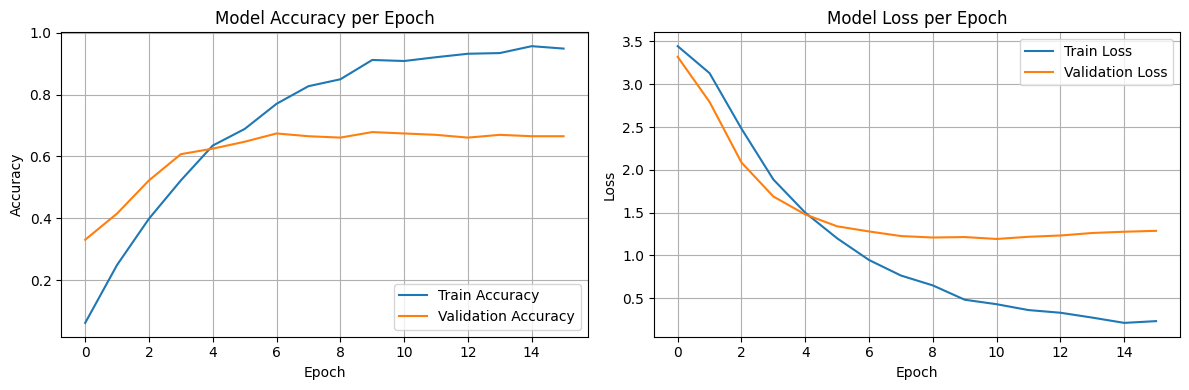

In [42]:
# Plot training history: accuracy & loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [43]:
# Load saved words and classes
words = pickle.load(open("words.pkl", "rb"))
classes = pickle.load(open("classes.pkl", "rb"))

print("Loaded preprocessed data:")
print(f"Words vocabulary size: {len(words)}")
print(f"Classes: {classes}")

Loaded preprocessed data:
Words vocabulary size: 924
Classes: ['1000 hari pertama', 'ASI eksklusif', 'MPASI', 'anak picky eater', 'aplikasi', 'berat badan anak', 'dampak stunting', 'deteksi dini', 'edukasi gizi', 'gizi seimbang', 'ibu hamil', 'imunisasi', 'kamu', 'keluarga berencana', 'konsultasi', 'kurva pertumbuhan', 'makanan penambah tinggi', 'notfound', 'olahraga anak', 'penanganan stunting', 'pencegahan stunting', 'pengertian stunting', 'penyebab stunting', 'posyandu', 'protein anak', 'sanitasi', 'sapaan', 'stimulasi anak', 'tanda stunting', 'terima kasih', 'tidak', 'tidur anak', 'vitamin anak']


In [44]:
def clean_up_sentence(sentence):
    """
    Tokenize and lemmatize the input sentence.
    
    Args:
        sentence (str): Input sentence to clean
    
    Returns:
        list: List of cleaned words
    """
    # Tokenize the sentence
    sentence_words = nltk.word_tokenize(sentence)
    # Lemmatize and lowercase each word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words


def bow(sentence, words, show_details=False):
    """
    Create bag of words array for the input sentence.
    
    Args:
        sentence (str): Input sentence
        words (list): Vocabulary list
        show_details (bool): Whether to show debug details
    
    Returns:
        numpy.array: Bag of words array
    """
    # Clean up sentence
    sentence_words = clean_up_sentence(sentence)
    # Initialize bag with zeros
    bag = [0] * len(words)
    
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                # Set bag element to 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print(f'Found in bag: {w}')
    
    return np.array(bag)


def predict_class(sentence, model):
    """
    Predict the class/intent of the input sentence.
    
    Args:
        sentence (str): Input sentence
        model: Trained Keras model
    
    Returns:
        list: List of predicted intents with probabilities
    """
    # Filter out predictions below a threshold
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    
    # Sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    
    return_list = []
    for r in results:
        return_list.append({
            "intent": classes[r[0]], 
            "probability": str(r[1])
        })
    
    return return_list


def get_response(ints, intents_json):
    """
    Get a random response for the predicted intent.
    
    Args:
        ints (list): List of predicted intents
        intents_json (dict): Intents JSON data
    
    Returns:
        str: Random response for the intent
    """
    if not ints:
        return "I'm sorry, I didn't understand that."
    
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    
    for i in list_of_intents:
        if tag == i['tag']:
            result = random.choice(i['responses'])
            break
    else:
        result = "I'm sorry, I didn't understand that."
    
    return result


def chatbot_response(msg):
    """
    Generate chatbot response for user message.
    
    Args:
        msg (str): User input message
    
    Returns:
        str: Chatbot response
    """
    ints = predict_class(msg, model)
    res = get_response(ints, intents)
    return res

print("Inference functions defined successfully!")

Inference functions defined successfully!


In [49]:
# Test the chatbot with some sample inputs
test_messages = [
    "makasih",
    "susah makan",
	"tinggi badan",
    "anak saya susah makan",
    "bagaimana cara mengatasi stunting",
    "apa itu stunting",
    "anak saya pendek",
    "anak saya tidak mau makan sayur",
    "bagaimana cara meningkatkan tinggi badan anak",
    "apa yang harus dilakukan jika anak tidak mau makan",
    "saya khawatir anak saya stunting",
    "apakah susu bisa membantu pertumbuhan anak",
    "berapa tinggi ideal anak usia 5 tahun",
    "anak saya sering sakit, apakah itu tanda stunting",
    "bagaimana cara mengetahui anak saya stunting"
]

print("Testing chatbot responses:")
print("=" * 40)

for msg in test_messages:
    response = chatbot_response(msg)
    print(f"User: {msg}")
    print(f"Bot: {response}")
    print("-" * 40)

Testing chatbot responses:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
User: makasih
Bot: saya selalu disini membantu anda
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
User: susah makan
Bot: Atasi anak picky eater dengan menyajikan makanan menarik, makan bersama keluarga, tidak memaksa, dan berikan contoh. Variasikan bentuk dan warna makanan agar anak tertarik.
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
User: tinggi badan
Bot: Untuk mendukung tinggi badan optimal: berikan makanan bergizi seimbang, pastikan tidur cukup, ajak anak beraktivitas fisik, dan hindari stres. Faktor genetik juga berpengaruh pada tinggi anak.
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
User: anak saya susah makan
Bot: Cara mengatasi anak susah makan: ciptakan suasana makan menyenangkan, libatkan anak dalam menyiapkan makanan, berikan pilihan terbatas, dan jangan jadikan makanan sebagai hadiah atau hukuman.
--------